# Homework 2 - eCommerce analytics

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

In [2]:
#Reading the csv file of October
dataset_Oct=pd.read_csv('2019-Oct.csv')

In [3]:
#Reading the csv file of November
dataset_Nov=pd.read_csv('2019-Nov.csv')

In [4]:
#Combine the two dataset in only one
dataset_Oct_Nov=[dataset_Oct,dataset_Nov]
dataset=pd.concat(dataset_Oct_Nov)

In [5]:
#reset the index of the concatenated dataset
dataset.reset_index(inplace=True, drop=True)

## The Dataset

In [6]:
#Our columns
dataset.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session'],
      dtype='object')

In [7]:
#which type of event?
dataset['event_type'].unique()

array(['view', 'purchase', 'cart'], dtype=object)

In [8]:
#The number of rows and columns
dataset.shape

(109950743, 9)

In [7]:
#The type of each column
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109950743 entries, 0 to 109950742
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 7.4+ GB


We should change the type of 'event_time' in datetime in order to use usefull functions.

In [6]:
dataset['event_time']= pd.to_datetime(dataset['event_time'])

# [RQ1] Which is the rate of complete funnels?



## What’s the operation users repeat more on average within a session?

In [16]:
#First we groupify the data by user sessions and event type.
df1 = dataset.groupby(["user_session", "event_type"]).count()

In [17]:
#Remove the useless columns.
df1 = df1.rename(columns={"event_time": "count"}).drop(columns=['product_id', 'category_id', 'category_code', 'brand', 'price', 'user_id'])

In [18]:
#take a look to the frame that created.
df1.head(10)

count
user_session                         event_type       
00000042-3e3f-42f9-810d-f3d264139c50 view            2
00000056-a206-40dd-b174-a072550fa38c view            8
0000007c-adbf-4ed7-af17-d1fef9763d67 view            1
00000083-8816-4d58-a9b8-f52f54186edc cart            1
                                     purchase        1
                                     view           16
0000009d-1f5b-40b9-bd23-db4f3d973ae3 view            1
000001d5-f8f8-4e40-b8d6-224155713521 view            1
000001fd-1f89-45e8-a3ce-fe3218cabfad cart            4
                                     purchase        1

In [19]:
df1.groupby("event_type").mean().sort_values('count', ascending=False)

,count
event_type,
view,4.535222
cart,1.707555
purchase,1.183232


On average in each ession, 4.5 view, 1.7 cart and 1.2 purchase happend.

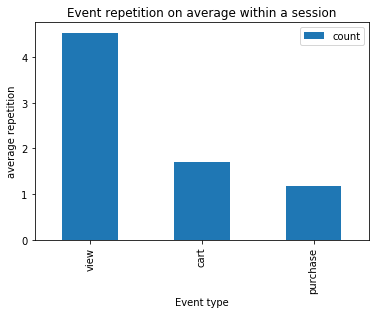

In [21]:
#Visualize the results of the above table.
df1.groupby("event_type").mean().sort_values('count', ascending=False).plot.bar()
plt.title('Event repetition on average within a session')
plt.xlabel('Event type')
plt.ylabel('average repetition')
plt.show()

The order view > cart > purchase is reasonable in Ecommerce field.

## How many times, on average, a user views a product before adding it to the cart?

In [90]:
"""
For the next parts of [RQ1], We used a smaller dataset, consist of first 500,000 rows in the dataset.
The reason is that running these algorithms are impossible on the original big dataset by our computers.
"""
dataset_s = dataset[:500000]

In [91]:
#Every add_to_cart in our smaller dataset. 
cart = dataset_s[ dataset_s["event_type"] == 'cart']

In [92]:
count = 0
#for each row in the 'cart' dataframe check the following in the dataset:
for index, row in cart.iterrows():
    df2 = dataset_s[ (dataset_s['product_id'] == row['product_id']) & (dataset_s['user_id'] == row['user_id']) 
                    & (dataset_s['event_type'] == 'view') & (dataset_s['event_time'] <= row['event_time'])] 
    if df2.size > 0:
        count += len(df2)

In [108]:
print("Average number of views before adding the product to the cart: ", count/len(cart))


Average number of views before adding the product to the cart:  2.4951837317160184


A product is viewed about 2.5 times on average before being added to the cart.

## What’s the probability that products added once to the cart are effectively bought?

In [98]:
counter = 0
#for each row in the 'cart' dataframe check the following in the dataset:
for index, row in cart.iterrows():
    df3 = dataset_s[ (dataset_s['product_id'] == row['product_id']) & (dataset_s['user_id'] == row['user_id']) 
                    & (dataset_s['event_type'] == 'purchase') & (dataset_s['event_time'] >= row['event_time'])] 
    if df3.size > 0:
        counter += len(df3)

In [109]:
print("Probability that products added once to the cart are effectively bought: ", counter/len(cart))

Probability that products added once to the cart are effectively bought:  0.7763110952550838


If a product is added to the cart, there is approximately 78% chance of buying.

## What’s the average time an item stays in the cart before being removed?

#### Because there is no event 'remove from cart' in our dataset, we considered purchase as removing.

In [100]:
#Every purchase in our smaller dataset.
purchase = dataset_s[ dataset_s["event_type"] == 'purchase']

In [101]:
difference = []
for index, row in purchase.iterrows():
    end = row['event_time']
    df4 = dataset_s[ (dataset_s['product_id'] == row['product_id']) & (dataset_s['user_id'] == row['user_id']) 
                    & (dataset_s['event_type'] == 'cart')]
    if df4.size > 0:
        start = df4['event_time'].max()
        if end > start:
            difference += [end-start]

In [110]:
print("Average time an item stays in the cart before purchase: ",
      sum(difference, datetime.timedelta())/ len(difference))

Average time an item stays in the cart before purchase:  0 days 00:03:20.637942


It takes an average of 3 minutes and 20 secods for customers to purchase a product added to the cart (if the product is purchased).

## How much time passes on average between the first view time and a purchase/addition to cart?

In [103]:
difference1 = []
for index, row in cart.iterrows():
    end = row['event_time']
    df5 = dataset_s[ (dataset_s['product_id'] == row['product_id']) & (dataset_s['user_id'] == row['user_id']) 
                    & (dataset_s['event_type'] == 'view')]
    if df5.size > 0:
        start = df5['event_time'].min() #used min() because we want the firs view
        if end > start:
            difference1 += [end-start]

In [118]:
print("Average time between the first view and adding the product to the cart: ",
      sum(difference1, datetime.timedelta())/ len(difference1))


Average time between the first view and adding the product to the cart:  0 days 00:19:45.498866


#### Average time between first view and purchase:

In [117]:
difference2 = []
for index, row in purchase.iterrows():
    end = row['event_time']
    df6 = dataset_s[ (dataset_s['product_id'] == row['product_id']) & (dataset_s['user_id'] == row['user_id']) 
                    & (dataset_s['event_type'] == 'view')]
    if df6.size > 0:
        start = df6['event_time'].min() #used min() because we want the firs view
        if end > start:
            difference2 += [end-start]

In [125]:
print("Average time between first view and purchase: ",
      sum(difference2, datetime.timedelta())/ len(difference2))


Average time between first view and purchase:  0 days 00:17:40.231008


##### The average time between the first view and adding the product to the cart is 19 min and 45 seconds, and this amount equals to 17 min and 40 seconds for the interval between the first view and purchase of the product. Normally the interval between first view and cart should be lower than the interval between first view and purchase, but we know that around 22% of what added to the cart never purchased. So these numbers can make sense.

# [RQ2] What are the categories of the most trending products overall? 


 The following plot shows the number of sold products per category in October:

<AxesSubplot:title={'center':'Number of sold Product for each category in October'}, xlabel='category_id', ylabel='number of sales'>

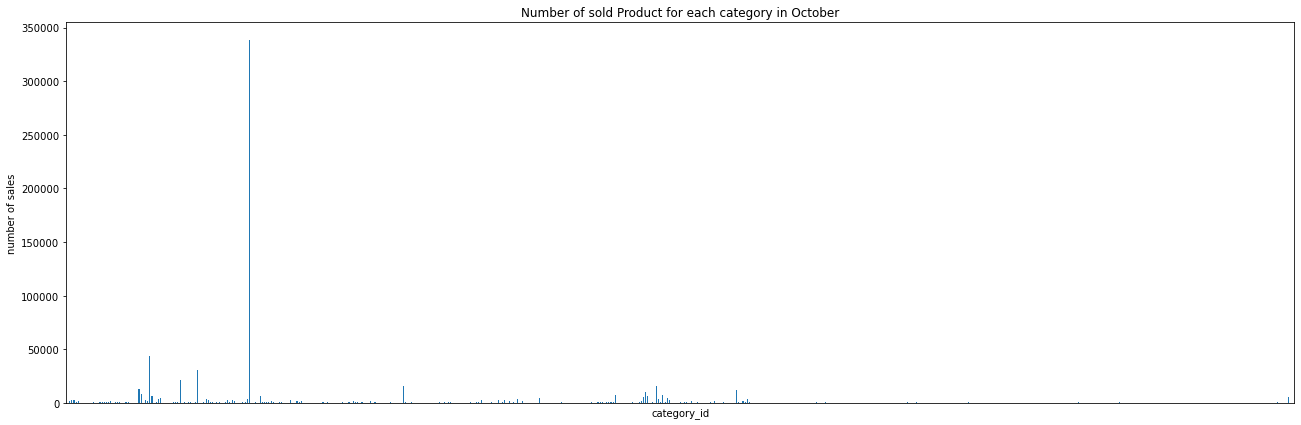

In [139]:
purchased=dataset_Oct[dataset_Oct.event_type=='purchase']
purchased.groupby(['category_id']).product_id.count().plot.bar(figsize=(22,7), xticks=[],
                                                               title='Number of sold Product for each category in October',
                                                               ylabel='number of sales')

In this dataset we have a large number of categories, exactly:

In [127]:
dataset_Oct['category_id'].nunique()

624

To let be the plot more readable let's consider just a sample categories, such as the first 50 categories

<AxesSubplot:title={'center':'Sold products per a sample category of October'}, xlabel='category_id', ylabel='number of sales'>

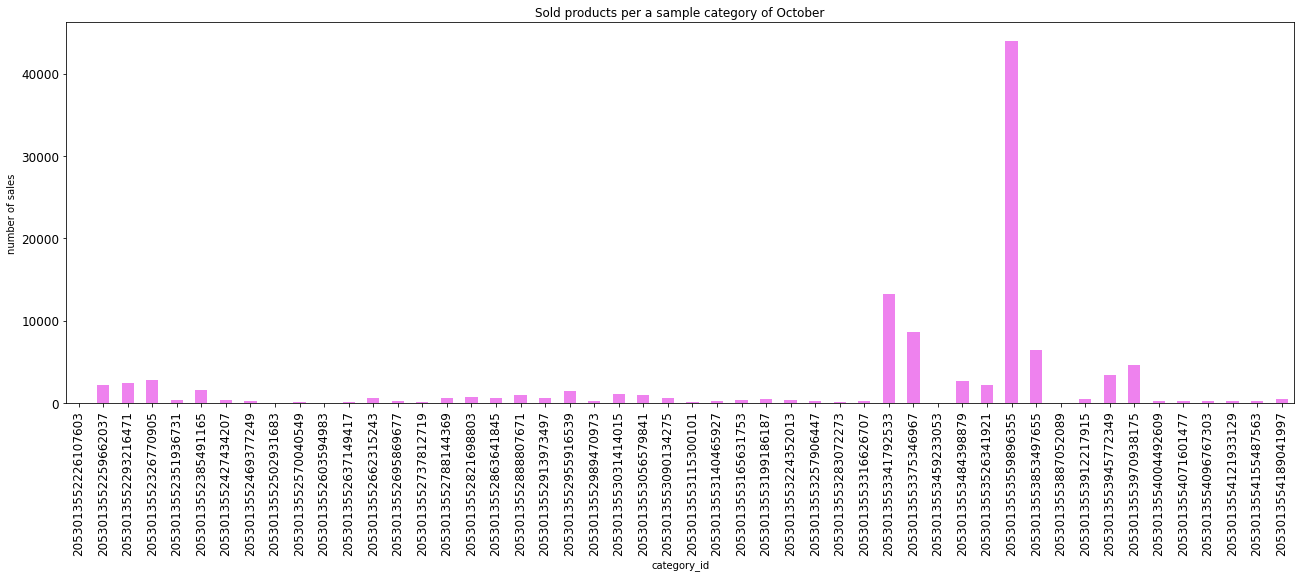

In [134]:
purchased=dataset_Oct[dataset_Oct.event_type=='purchase']
purchased.groupby(['category_id']).product_id.count().head(50).plot.bar(figsize=(22,7), fontsize=12, color='violet',
                                                                        title='Sold products per a sample category of October',
                                                                        ylabel='number of sales'   )

Through the plot we can see that in our sample the category which has the most sold product is the one with id 2053013553559896355.

Let's see what happens if we consider the categories with the largest number of sold product of the whole dataset of October.

<AxesSubplot:title={'center':'Most sold products per category of October'}, xlabel='category_id', ylabel='number of sales'>

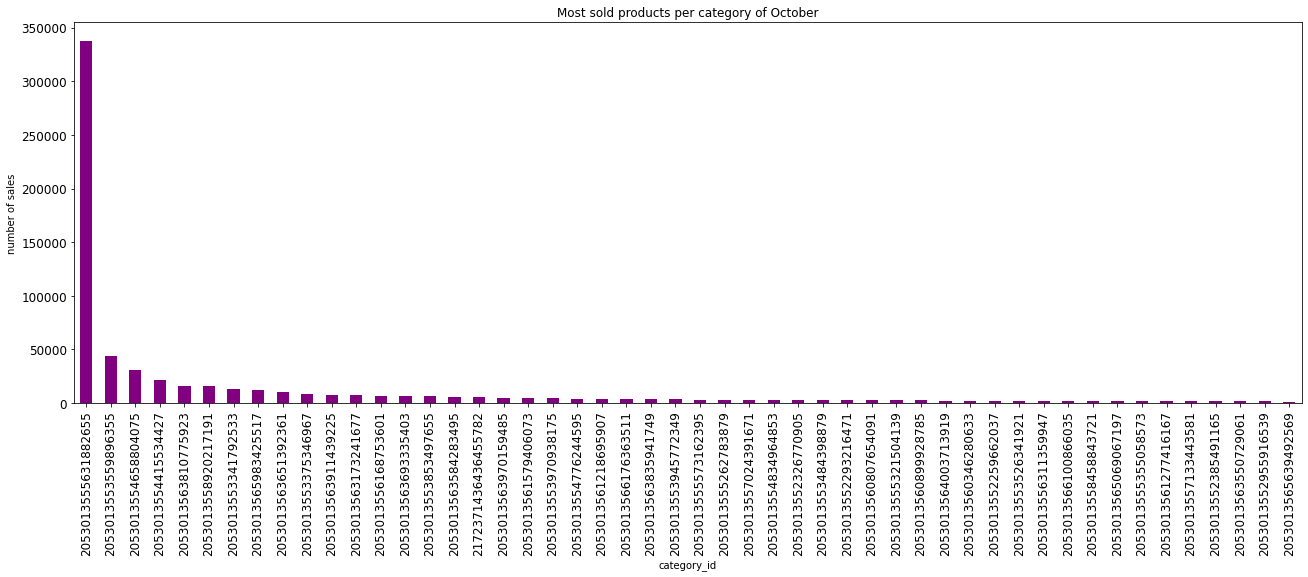

In [138]:
purchased=dataset_Oct[dataset_Oct.event_type=='purchase']
purchased.groupby(['category_id']).product_id.count().sort_values(ascending=False).head(50).plot.bar(figsize=(22,7), fontsize=12, color='purple',
                                                                          title='Most sold products per category of October',
                                                                           ylabel='number of sales')

So, in the entire dataset of October, the category which has the most sold product is 2053013555631882655. There is a huge different of about 30,000 sales between the first and the second product (which belong to the category 2053013553559896355 encountered in the previous plot), after this altitude difference the decreasing is more gradual.

In the next plot we will show the development in November.

<AxesSubplot:title={'center':'Number of sold Product for each category in November'}, xlabel='category_id', ylabel='number of sales'>

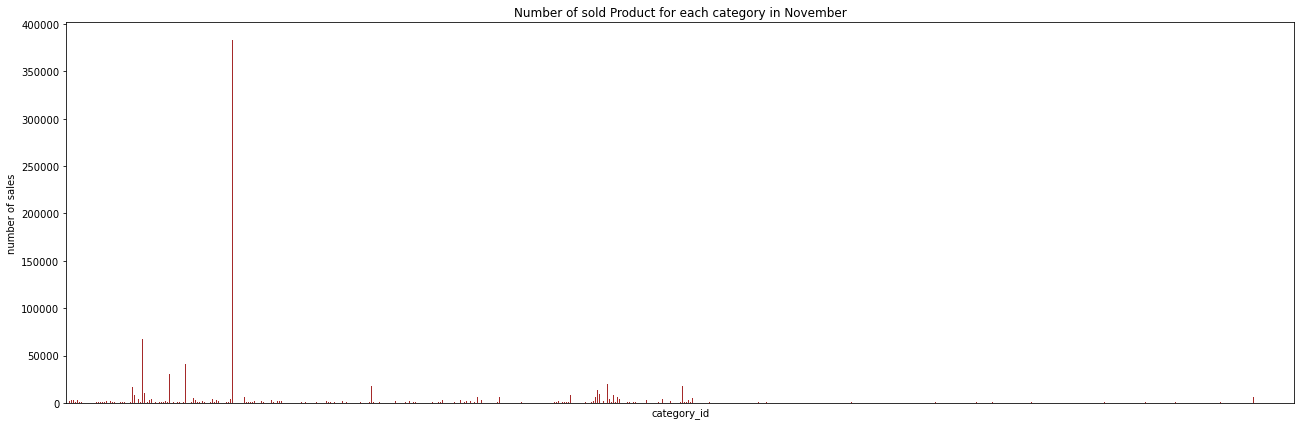

In [142]:
purchased_N=dataset_Nov[dataset_Nov.event_type=='purchase']
purchased_N.groupby(['category_id']).product_id.count().plot.bar(figsize=(22,7),xticks=[], color='brown',
                                                               title='Number of sold Product for each category in November',
                                                               ylabel='number of sales')

<AxesSubplot:title={'center':'number of the most sold products per category of November'}, xlabel='category_id', ylabel='number of sales'>

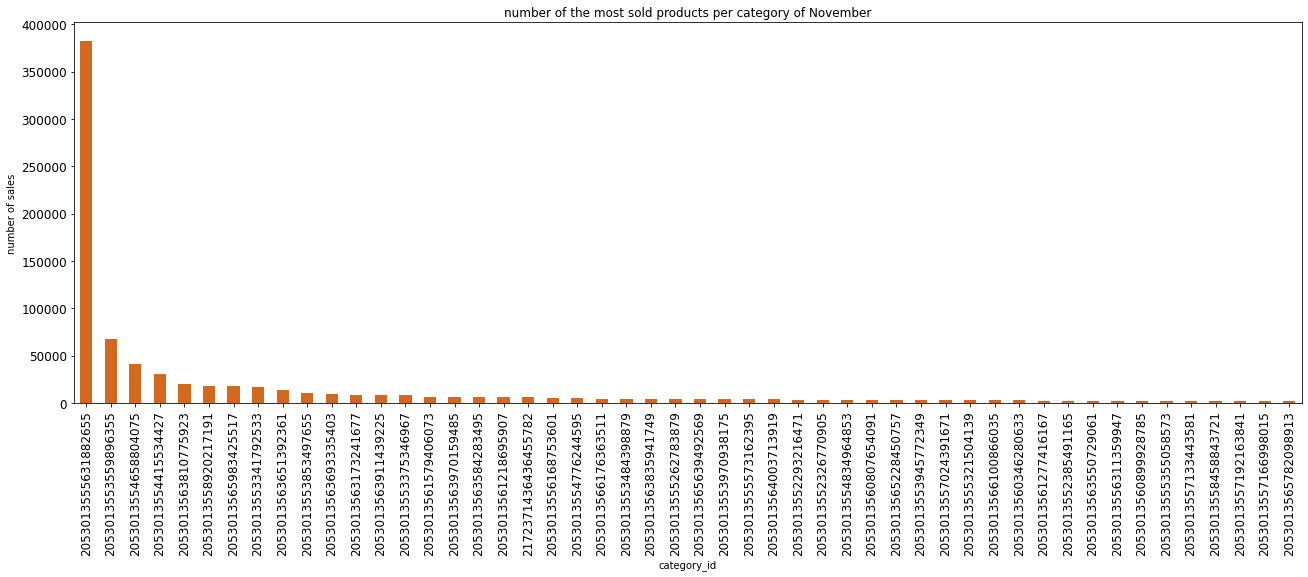

In [144]:
purchased_N.groupby(['category_id']).product_id.count().sort_values(ascending=False).head(50).plot.bar(figsize=(22,7), fontsize=12, color='chocolate',
                                                                          title='number of the most sold products per category of November',
                                                                           ylabel='number of sales'
                                                                           )

Also in November the category with id 2053013555631882655 was the one with the most sold product. Also the trend of the bar plot is similar to the one of October, but we can see that the sales went better since the most sold category has about 40,000 products sold respect the about 35,000 on October.

The category_id  2053013555631882655 is about smartphone:

In [12]:
dataset_Oct[dataset_Oct.category_id==2053013555631882655].category_code.head(1)

4    electronics.smartphone
Name: category_code, dtype: object

## Most visited subcategories

If we consider as subcategories the product's category taxonomy present in 'category_code', the ten most visited subcategories are:

<AxesSubplot:title={'center':'Most visited subcategory of October'}, xlabel='category_code', ylabel='number of views'>

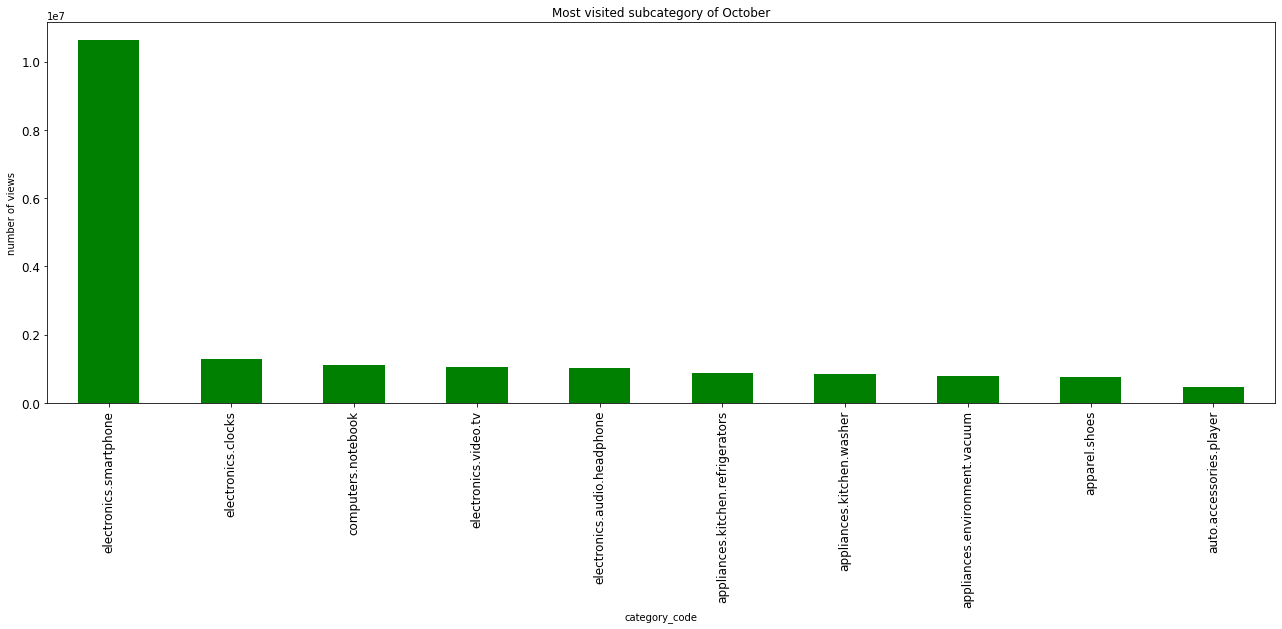

In [146]:
view=dataset_Oct[dataset_Oct.event_type=='view']
#Not every record has a category_code
view_subcategory=view[view.category_code.notnull()]
view_subcategory.groupby(['category_code']).category_code.count().sort_values(ascending=False).head(10).plot.bar(figsize=(22,7), 
                                                                                                                 fontsize=12, 
                                                                                                                 color='green',
                                                                          title='Most visited subcategory of October',
                                                                          ylabel='number of views')

The most visited subcategories are about smarthphones. We expected that since the most purchased product was always smartphones.
The other subcategories have more or less the same number of views, only in the first bar we can see a huge difference towards all the other. In general trend product are about elettronics (smartphone, clock, notebook, tv, headphone), followed up by appliances (refrigerators, washer, vacuum).

<AxesSubplot:title={'center':'Most visited subcategory of November'}, xlabel='category_code', ylabel='number of views'>

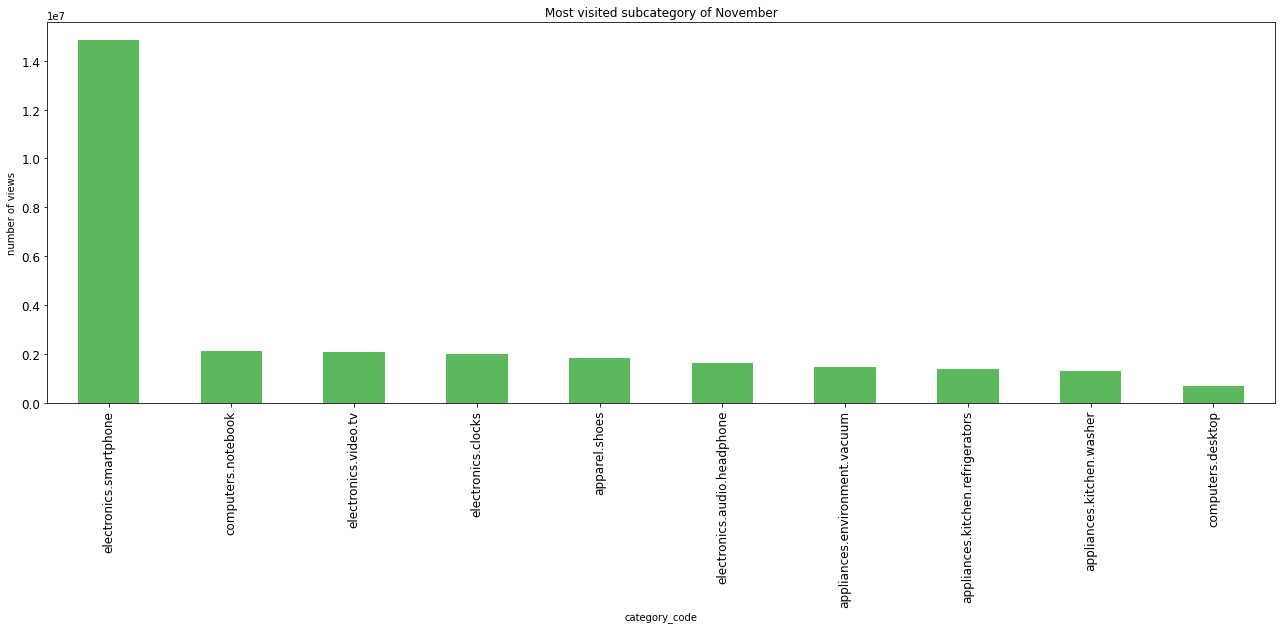

In [147]:
view=dataset_Nov[dataset_Nov.event_type=='view']
view_subcategory=view[view.category_code.notnull()]
view_subcategory.groupby(['category_code']).category_code.count().sort_values(ascending=False).head(10).plot.bar(figsize=(22,7), 
                                                                                                                 fontsize=12, 
                                                                                                                 color='#5cb85c',
                                                                          title='Most visited subcategory of November',
                                                                          ylabel='number of views')

Things change a little in November, for example in this month the second subcategory we meet is about notebook but the most sold subcategory is the same of October, which still presents a big discrepancy towards the others.
The fifth bar in this case represents shoes instead of headphones.

## What are the 10 most sold products per category?

To answer this question we can provide a double groupby and count the number of sold product for each category.

In [148]:
purchased=dataset_Oct[dataset_Oct.event_type=='purchase']
purchased.groupby(['category_id','product_id'])['product_id'].agg(['count']).sort_values(by='count', ascending=False)#.reset_index()#.drop_duplicates('category_id')

count
category_id         product_id       
2053013555631882655 1004856     28944
                    1004767     21806
                    1004833     12697
                    1005115     12543
2053013554658804075 4804056     12381
...                               ...
2053013559901684381 16700057        1
                    16700032        1
                    16700016        1
                    16700014        1
2175419595093967522 50700065        1

[42241 rows x 1 columns]

In [153]:
purchased_N=dataset_Nov[dataset_Nov.event_type=='purchase']
purchased_N.groupby(['category_id','product_id'])['category_id'].agg(['count']).sort_values(by='count',ascending=False)


count
category_id         product_id       
2053013555631882655 1004856     32321
                    1004767     22613
                    1005115     22244
2053013554658804075 4804056     17800
2053013555631882655 1004833     13486
...                               ...
2053013560346280633 7006012         1
                    7006007         1
                    7006003         1
                    7005995         1
2187707789055361298 100026889       1

[52054 rows x 1 columns]

As the table shows, in our datasets not every category has 10 different products. We can answer this question considering the top product for each category.

In [154]:
purchased=dataset_Oct[dataset_Oct.event_type=='purchase']
purchased.groupby(['category_id','product_id'])['product_id'].agg(['count']).sort_values(by='count', ascending=False).reset_index().drop_duplicates('category_id')

,category_id,product_id,count
0,2053013555631882655,1004856,28944
4,2053013554658804075,4804056,12381
10,2053013553375346967,5100816,7273
29,2053013554415534427,1801690,2745
47,2053013565983425517,3700926,1675
...,...,...,...
30529,2053013565681435611,28708782,1
41536,2053013559406756479,20300051,1
41546,2053013559289315959,20700547,1
41547,2053013559222207091,20800006,1


In [155]:
purchased_N=dataset_Nov[dataset_Nov.event_type=='purchase']
purchased_N.groupby(['category_id','product_id'])['product_id'].agg(['count']).sort_values(by='count', ascending=False).reset_index().drop_duplicates('category_id')

,category_id,product_id,count
0,2053013555631882655,1004856,32321
3,2053013554658804075,4804056,17800
12,2053013553375346967,5100816,6725
27,2053013554415534427,1801690,3086
30,2053013561218695907,4100346,2824
...,...,...,...
49324,2053013559138321009,21600233,1
49673,2053013557737423389,1480000,1
51701,2053013560581161671,22600055,1
51993,2053013560388223675,8400179,1


In the coloumn 'count' we can observe the number of sales of the top one product, for each category.\
The table is ordered by count so in the first line we have the most sold product of all that belong to the category 2053013555631882655 in both the datasets. On November the sales of this item went a little bit better since we have count equal to 32321 compared to the 28944 on October.

# [RQ3] For each category, what’s the brand whose prices are higher on average?

## Average price of the products sold by the brand

In this function we ask as input the category_id to examinate and as output we return the plot which indicate the average price of the products sold by the brand of that category inserted.

In [ ]:
print('Please, insert the category ID you are interested in')
cat=int(input())
#We are interested only in the category inserted in input
category=dataset[dataset.category_id==cat]
category_with_brand=category[category.brand.notnull()]
category_with_brand.groupby('brand').price.mean().plot.bar(title='Average price of the products sold by the brand',
                                                                     xlabel='Brand',
                                                                     ylabel='Average Price',
                                                                     color='red',
                                                                     figsize=(18,7),
                                                                     fontsize=12)

Let's use the category_id 2053013555631882655	as example:

<AxesSubplot:title={'center':'Average price of the products sold by the brand'}, xlabel='Brand', ylabel='Average Price'>

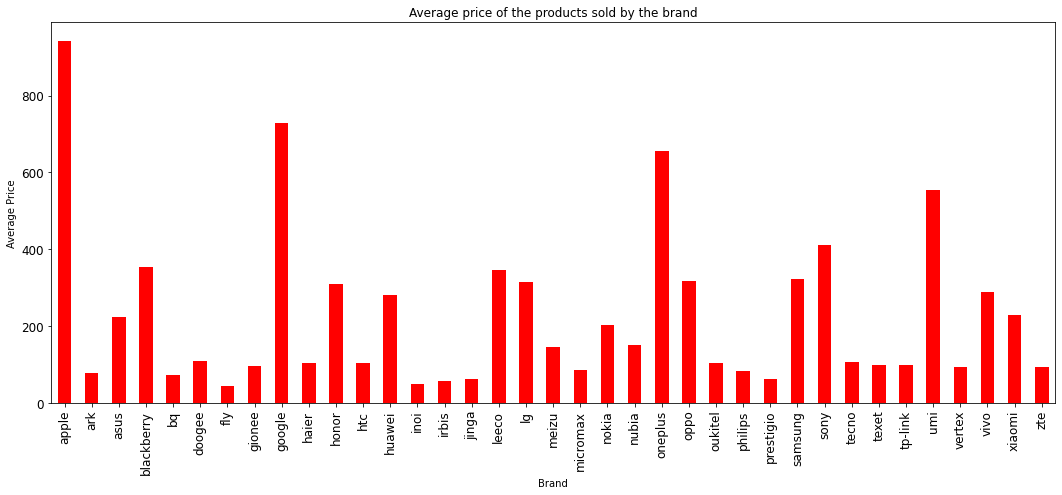

In [67]:
cat=int(2053013555631882655)
dataset[dataset.event_type=='purchase']
category=dataset[dataset.category_id==cat]
category_with_brand=category[category.brand.notnull()]
category_with_brand.groupby('brand').price.mean().plot.bar(title='Average price of the products sold by the brand',
                                                                     xlabel='Brand',
                                                                     ylabel='Average Price',
                                                                     color='red',
                                                                     figsize=(18,7),
                                                                     fontsize=12)

This category seems to be about electronic item and the most expensive brand is 'apple'.

## Brand with the highest average price per category

For each category, we'll show the brand with the highest average price and we'll return all the results in ascending order by price

In [10]:
ds=dataset[dataset.brand.notnull()]
s=ds.groupby(['category_id','brand'])['price'].mean()
s.loc[s.groupby(level=0).idxmax()].sort_values()

category_id          brand             
2155241212938814273  studioprofessional       2.135391
2053013559071212141  kabrita                  2.157500
2075962341706433246  crockid                  3.220000
2076715364279910943  crockid                  3.320758
2070747685681365440  koopman                  4.890000
                                              ...     
2053013559733912211  pinskdrev             2409.933007
2053013560555995845  panasonic             2416.737374
2053013564674802599  nordictrack           2522.590000
2116907525176557699  pinarello             2533.238401
2053013554591695207  fly                   2562.630000
Name: price, Length: 683, dtype: float64

In the last column of the last output we have the average price of the most expensive brand in that specific category in ascending order. You can observe that at first there's a very cheap price and then the average price increase  gradually until two thousand and more.

# [RQ4] How much does each brand earn per month? 

Now, our purpose is to write a function that given the name of a brand in input returns, for each month, it's profit.

In [158]:
print('Please, insert the name of the brand')
b=str(input())
purchased=dataset_Oct[dataset_Oct.event_type=='purchase']
print(purchased[purchased.brand==b].price.sum())
print('This is the profit of the brand in October.')

Please, insert the name of the brand
acer
3576719.52
This is the profit of the brand in October.


In [159]:
print('Please, insert the name of the brand')
b=str(input())
purchased=dataset_Nov[dataset_Nov.event_type=='purchase']
print(purchased[purchased.brand==b].price.sum())
print('This is the profit of the brand in November.')

Please, insert the name of the brand
acer
3347306.5300000003
This is the profit of the brand in November.


The profit of a brand is due to the purchase event, so first of all we filter only this kind of event, then we do the same of the various price.

As example we can see that 'acer' brand has earned more in October.

## Is the average price of products of different brands significantly different?

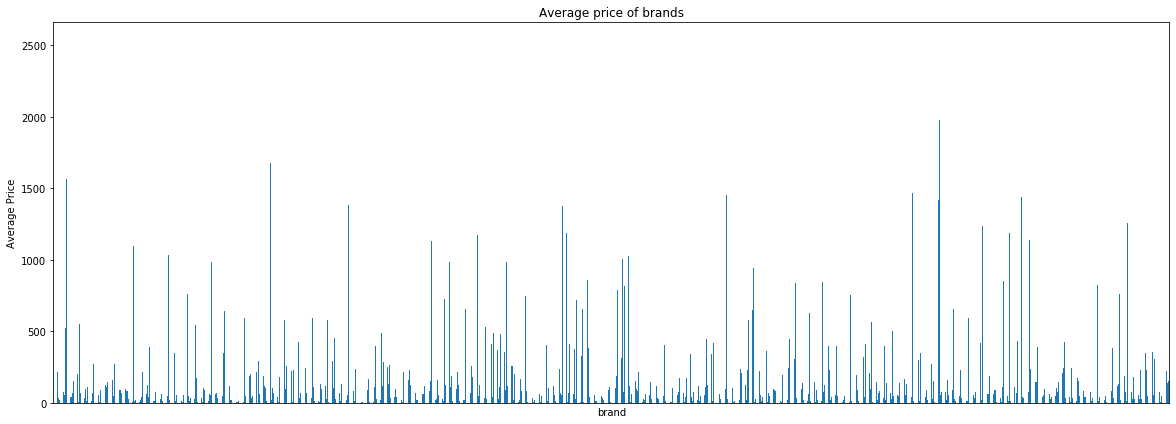

In [89]:
br=dataset[dataset.brand.notnull()]
#xticks removed to let the plot more clean
br.groupby('brand').price.mean().plot.bar(figsize=(20,7), xticks=[])
plt.title('Average price of brands')
plt.ylabel('Average Price')
plt.show()

We can see a huge difference among brands, so the answer to this question is yes.

We can provide a numerical example considering the first five brands:

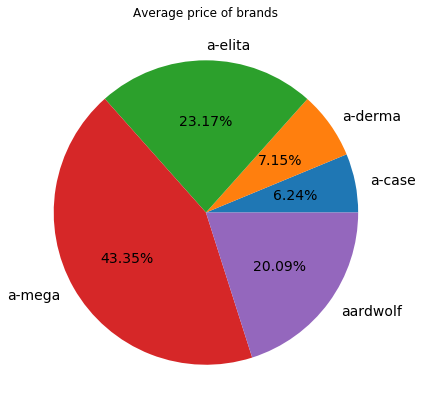

In [13]:
br.groupby('brand').price.mean().head(5).plot.pie(figsize=(7,7), autopct='%.2f%%', fontsize=14)
plt.title('Average price of brands')
plt.ylabel('')
plt.show()

a-mega earned more than two times more than aardwolf.

## Top 3 brands that have suffered the biggest losses 

In [166]:
purchased_N=dataset_Nov[dataset_Nov.event_type=='purchase']
purchased_O=dataset_Oct[dataset_Oct.event_type=='purchase']
notnull_N=purchased_N[purchased_N.brand.notnull()]
notnull_O=purchased_O[purchased_O.brand.notnull()]
diff=notnull_O.groupby('brand').price.sum()-notnull_N.groupby('brand').price.sum()
(diff/notnull_O.groupby('brand').price.sum()).sort_values(ascending=False).head(3)*100

brand
jonnesway    96.624338
sunfull      96.000000
evga         95.899730
Name: price, dtype: float64

The last column show the loss profit in percentage between November and October, so jonnesway is the one which has the biggest loss in November compared to October; jonnesway sunfull and evga have a very similar behaviour, the difference between these three value is virtually undetectable.


# [RQ5] In what part of the day is your store most visited?

In [7]:
#Every views in our dataset.
view = dataset[ dataset["event_type"] == 'view']

In [8]:
#Convert data to the required format.
view['hour'] = view['event_time'].dt.hour
view['date'] = view['event_time'].dt.date
view['day_of_week'] = view['event_time'].dt.day_name()
view['week'] = view['event_time'].dt.week

D:\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Python\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [9]:
# Aggregate data based on days of week and ours of days to find hourly average for every hour in days of week.
weekly_hours_visits = view.groupby(["day_of_week", "hour"]).date.count()/view.groupby(["day_of_week", "hour"]).date.nunique()

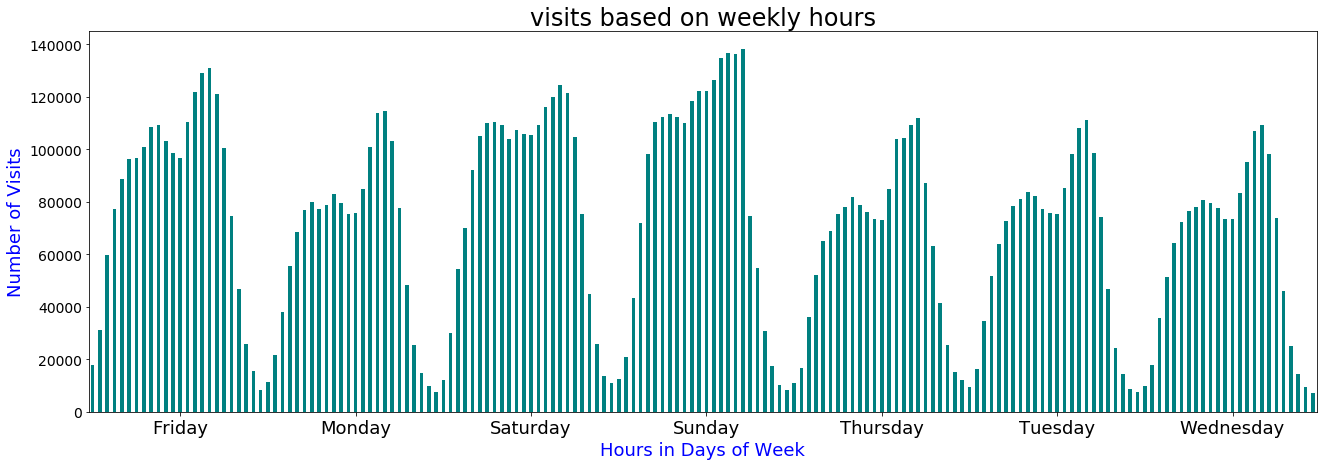

In [61]:
weekly_hours_visits.plot.bar(figsize=(22,7), color='teal')
plt.title('visits based on weekly hours', fontsize = 24)
plt.xlabel('Hours in Days of Week', fontsize = 18, color='blue')
plt.ylabel('Number of Visits', fontsize = 18, color='blue')
plt.yticks(fontsize = 14)
plt.xticks(range(12,157,24),["Friday","Monday","Saturday","Sunday","Thursday","Tuesday","Wednesday"], fontsize = 18, rotation = 0 )
plt.show()

It seems that the site has received more visitors on average over the weekend. On average, between 2-5 PM  site had the most visits.

# [RQ6] Find the overall conversion rate of your store.

In [29]:
bought = len(dataset[dataset['event_type'] == 'purchase'])
visited = len(dataset[dataset['event_type'] == 'view'])

In [30]:
# overall conversion rate
bought/visited

0.01590817944828352

Just around 1.6% of visits end up buying.

## Plot the number of purchases of each category and show the conversion rate of each category.

In [23]:
# We want the  purchases per each category.
p = dataset[dataset["event_type"] == 'purchase']
purchase_count = p.groupby(['category_id']).user_session.count()

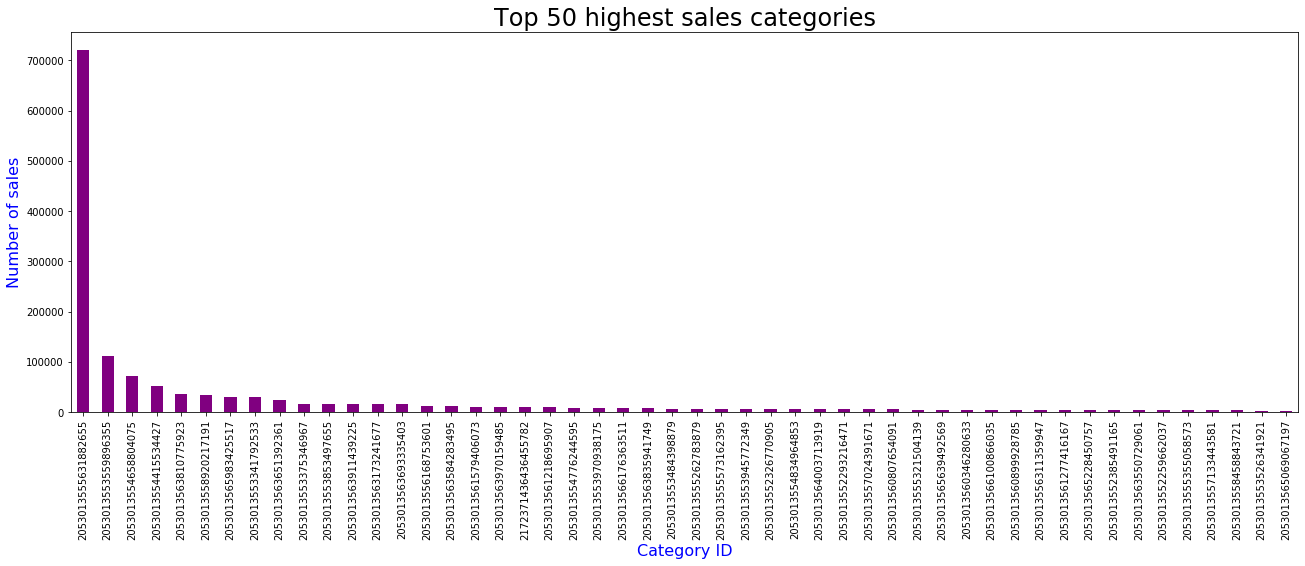

In [28]:
purchase_count.sort_values(ascending=False).head(50).plot.bar(figsize=(22,7), color='purple')
plt.title('Top 50 highest sales categories', fontsize = 24)
plt.xlabel('Category ID', fontsize = 16, color='blue')
plt.ylabel('Number of sales', fontsize = 16, color='blue')
plt.show()

The electronics.smartphone category has highest sale rate with great difference compare to the second category.

In [24]:
# We want the views per each category.
v = dataset[dataset["event_type"] == 'view']
view_count = v.groupby(['category_id']).user_session.count()

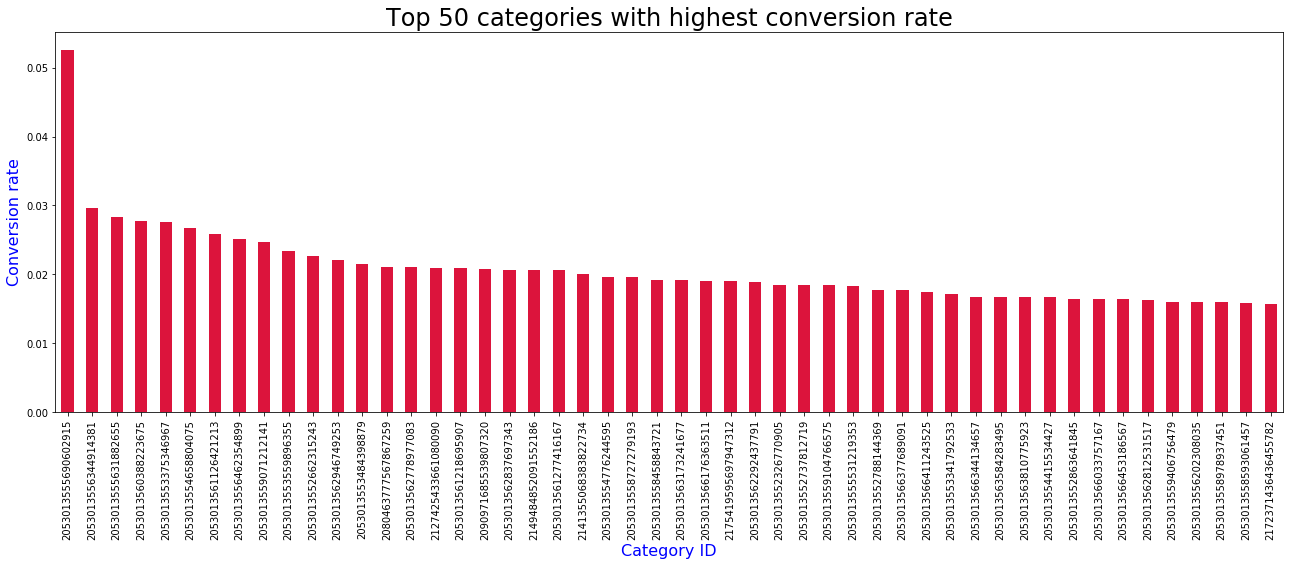

In [27]:
(purchase_count/view_count).sort_values(ascending=False).head(50).plot.bar(figsize=(22,7), color='crimson')
plt.title('Top 50 categories with highest conversion rate', fontsize = 24)
plt.xlabel('Category ID', fontsize = 16, color='blue')
plt.ylabel('Conversion rate', fontsize = 16, color='blue')
plt.show()


Products that have the highest conversation rate have no defined category. After that baby dipers stand in the second place. 

# [RQ7] Prove that the pareto principle applies to your store

Pareto Principle, or 80/20 rule, states that 80% of some effect is accounted for by 20% of contributory effects.The Pareto principle applies to wide range of fields from natural science to sports, but it's particularly suited to solving business problems. In our case means that most of the business, around 80%, likely comes from about 20% of the customers.


We are going to show the behaviour of our customers in October and for costumers we mean the totality of users.

In [82]:
#total profit
t_p=dataset[dataset.event_type=='purchase'].price.sum()
print('Total profit:',t_p)
#80% of the profit
print('80% of the profit:',(t_p*80)/100)

Total profit: 505152392.76999974
80% of the profit: 404121914.2159998


In [83]:
#how many users
t_u=dataset.user_id.nunique()
#20% of the users
v_u=int((t_u*20)/100)
print('Total user:',t_u)
print('20% of the users:',v_u)

Total user: 5316649
20% of the users: 1063329


In [84]:
v_u=int((t_u*20)/100)
#how much spend each user;ordered in descending order;select the first 20 percent 
dataset[dataset.event_type=='purchase'].groupby('user_id').price.sum().sort_values(ascending=False).head(v_u)

user_id
512386086    344153.29
515384420    303144.24
513117637    266331.24
519267944    265569.52
518514099    203986.07
               ...    
513377188         0.88
517557126         0.87
524830675         0.87
513378422         0.79
520573734         0.77
Name: price, Length: 697470, dtype: float64

In [85]:
#profit due to the top 20% users
dataset[dataset.event_type=='purchase'].groupby('user_id').price.sum().sort_values(ascending=False).head(v_u).sum()

505152392.7699998

So the 20% of costumers represents exactly the 100% of the profits. This is due to the fact that the customers that actually buy products is less that the 20% of the all guests: 


In [86]:
dataset[dataset.event_type=='purchase'].user_id.nunique()

697470

Let's consider the totality of customers as the customers that have bought at least one product

In [87]:
#20% of "active" customers
v_u_p=(dataset[dataset.event_type=='purchase'].user_id.nunique()*20)/100
##profit due to the top 20% 'active' users
dataset[dataset.event_type=='purchase'].groupby('user_id').price.sum().sort_values(ascending=False).head(int(v_u_p)).sum()

364222233.81

In [88]:
#total profit
t_p=dataset[dataset.event_type=='purchase'].price.sum()
print('Total profit:',t_p)
#72% of the profit
print('72% of the profit:',(t_p*72)/100)

Total profit: 505152392.76999974
72% of the profit: 363709722.7943998


 This result shows that, in this case, the 20% of 'active' customers represents about the 72% of the total profit.